<a href="https://colab.research.google.com/github/titocampos/estudo-crm/blob/master/finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Neste tutorial, criaremos um gráfico candlestick / OHLC com base na coluna Adj Close, para praticar a visualização de dados.
Um gráfico OHLC, chamado gráfico de candlestick, é um gráfico que condensa os valores open, high, low e close.

source: [https://pythonprogramming.net/getting-stock-prices-python-programming-for-finance/]

In [8]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
import matplotlib.dates as mdates
style.use('ggplot')

!pip install https://github.com/matplotlib/mpl_finance/archive/master.zip
from mpl_finance import candlestick_ohlc


     - 747kB 27.3MB/s
  Created wheel for mpl-finance: filename=mpl_finance-0.10.0-cp36-none-any.whl size=6903 sha256=70720aed188d8cac370eb2e348dce0b1bb86dfa0260c8b2907016f91fa943d90
  Stored in directory: /tmp/pip-ephem-wheel-cache-q2nna2xy/wheels/8f/bf/8a/6c858b2a3be945c7b2d658fbf6ab797b451d686cbee8aa2679
Successfully built mpl-finance


Carregando dados alvo

In [0]:
start = dt.datetime(2018, 1, 1)
end = dt.datetime.now()
df = web.DataReader("TSLA", 'yahoo', start, end)
df.reset_index(inplace=True)
df.set_index("Date", inplace=True)


Vamos criar nossos próprios dados OHLC, o que também nos permitirá mostrar outra transformação de dados que vem do Pandas:

In [0]:
df_ohlc = df['Adj Close'].resample('10D').ohlc()

O que fizemos aqui foi criar um novo dataframe, com base na coluna df 'Adj Close', redefinida com uma janela de 10 dias, e a redefinição de amostra é um ohlc. Também podemos fazer coisas como .mean() ou .sum(),  para médias de 10 dias ou somas de 10 dias. Lembre-se de que essa média de 10 dias será uma média de 10 dias e não uma média móvel. Como nossos dados são diários, a amostragem para 10 dias reduz efetivamente o tamanho dos dados. É assim que você pode normalizar vários conjuntos de dados. Às vezes, você pode ter dados que rastreiam uma vez por mês no primeiro dia do mês, outros dados que registram no final de cada mês e, finalmente, alguns dados que registram semanalmente. Você pode reamostrar esses dados até o final do mês, todos os meses, e normalizar tudo efetivamente! Esse é um dos recursos mais avançado do Pandas.

In [0]:
df_volume = df['Volume'].resample('10D').sum()

Estamos usando soma aqui, já que realmente queremos saber o volume total negociado nesses 10 dias.

Agora queremos mover essas informações para o matplotlib, além de converter as datas para a versão mdates. Como apenas vamos representar graficamente as colunas no Matplotlib, na verdade não queremos mais que a data seja um índice.

In [0]:
df_ohlc = df_ohlc.reset_index()
df_ohlc['Date'] = df_ohlc['Date'].map(mdates.date2num)


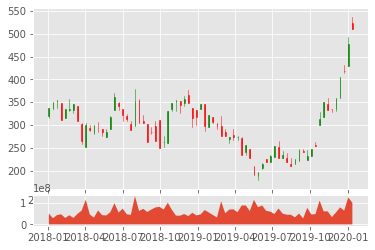

In [17]:
fig = plt.figure()
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1,sharex=ax1)
ax1.xaxis_date() #converte mdate em date

candlestick_ohlc(ax1, df_ohlc.values, width=2, colorup='g')
ax2.fill_between(df_volume.index.map(mdates.date2num),df_volume.values,0)
plt.show()

In [0]:
import bs4 as bs
import datetime as dt
import os
import pandas_datareader.data as web
import pickle
import requests
import time
import numpy as np

In [0]:
def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers


In [0]:
def get_data_from_yahoo(reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle", "rb") as f:
            tickers = pickle.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')

    start = dt.datetime(2018, 1, 1)
    end = dt.datetime.now()
    for i, ticker in enumerate(tickers):
        # just in case your connection breaks, we'd like to save our progress!
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            try:
              ticker = ticker.rstrip()
              print(repr(ticker))
              df = web.DataReader(ticker, 'yahoo', start, end)
              df.reset_index(inplace=True)
              df.set_index("Date", inplace=True)
              df.to_csv('stock_dfs/{}.csv'.format(ticker))
            except:
              pass
        else:
            print('Already have {}'.format(ticker))
        
        if (i % 10 == 0  and i > 0):
          print("Processado {}%".format( i / 500.0 * 100.0)) 
        time.sleep(2)

In [0]:
def compile_data():
    with open("sp500tickers.pickle", "rb") as f:
        tickers = pickle.load(f)

    main_df = pd.DataFrame()

    for count, ticker in enumerate(tickers):
        ticker = ticker.rstrip()
        if os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
            df.set_index('Date', inplace=True)

            df.rename(columns={'Adj Close': ticker}, inplace=True)
            df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], 1, inplace=True)

            if main_df.empty:
                main_df = df
            else:
                main_df = main_df.join(df, how='outer')

        if count % 10 == 0:
            print(count)
   
    print(main_df.head())
    main_df.to_csv('sp500_joined_closes.csv')

In [0]:
def visualize_data():
    df = pd.read_csv('sp500_joined_closes.csv')
    df_corr = df.corr()
    df_corr.to_csv('sp500corr.csv')
    data1 = df_corr.values
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)

    heatmap1 = ax1.pcolor(data1, cmap=plt.cm.RdYlGn)
    fig1.colorbar(heatmap1)

    ax1.set_xticks(np.arange(data1.shape[1]) + 0.5, minor=False)
    ax1.set_yticks(np.arange(data1.shape[0]) + 0.5, minor=False)
    ax1.invert_yaxis()
    ax1.xaxis.tick_top()
    column_labels = df_corr.columns
    row_labels = df_corr.index
    ax1.set_xticklabels(column_labels)
    ax1.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    heatmap1.set_clim(-1, 1)
    plt.tight_layout()
    plt.show()

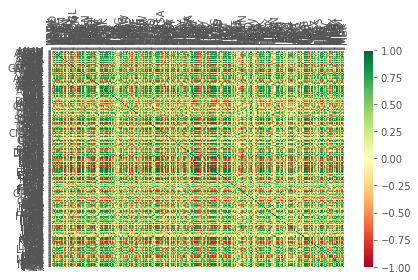

In [56]:
#save_sp500_tickers()
#get_data_from_yahoo()
#compile_data()
visualize_data()

In [0]:
!ls -l stock_dfs